<a href="https://colab.research.google.com/github/Nagisa1002/iris/blob/main/iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [380]:
'''
ライブラリ読み込み
'''
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay


from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from sklearn import preprocessing
from sklearn.model_selection import  KFold, StratifiedKFold

In [381]:
'''
パラメータ設定
'''
test_size = 0.2
epochs=300
batch_size=10

データセット
- 150個のデータ
- １データは特徴量を4つ持つ
- 3種類の花が格納


特徴量
- sepal length : ガクの長さ
- sepal width	: ガクの幅
- petal length : 花弁の長さ
- petal width :	花弁の幅

花の種類
- 0 : setosa
- 1 : versicolor
- 2 : virginica



In [382]:
def load_data():
  '''
  データ準備
  '''
  iris = datasets.load_iris() 
  X = iris.data # (150, 4)のデータ
  y = iris.target #0~2のラベル(150, )

  X=preprocessing.scale(X)

  label = iris.target_names
  return X, y, label

def get_data(X,y,train_index, test_index):
  '''
  データを訓練，テスト，検証に分ける
  '''
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test = X[test_index], y[test_index]
  X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=y_train)  
  y_tr = np_utils.to_categorical(y_tr)
  y_val = np_utils.to_categorical(y_val)

  return X_tr, X_val, y_tr, y_val, X_test, y_test


In [383]:
def plot_history(model):
  '''
  学習曲線のプロット
  '''
  plt.plot(model.history["accuracy"], label="acc")
  plt.plot(model.history["loss"], label="loss")
  plt.xlabel("epoch")
  plt.legend()

In [384]:
def define_model(num_classes, feature):
  '''
  モデル作成
  '''
  model = Sequential()
  model.add(Dense(num_classes, input_dim=feature)) #全結合層
  model.add(Activation('softmax')) #活性化関数
  model.compile(loss='categorical_crossentropy', #誤差関数
                optimizer=SGD(learning_rate=0.1), #最適化手法
                metrics=['accuracy']
                )
  return model
  
def train_model(label, X_train, y_train, X_val, y_val):
  '''
  トレーニング
  '''
  model =define_model(len(label), X_train.shape[1])
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0 ,patience=15, verbose=0, mode='auto')
  reduce_lr_on_plateau = ReduceLROnPlateau(factor=0.2, patience=5, verbose=0, min_lr=0.000001)
  callbacks = [early_stopping, reduce_lr_on_plateau]

  history=model.fit(X_train, y_train, 
            epochs=epochs, 
            batch_size=batch_size,
            verbose=0,
            callbacks = callbacks,
            validation_data = (X_val, y_val)
            )
  #plot_history(history) #学習曲線をプロットする
  return model

In [385]:
def predict(X, y, score_dict, y_dict, model):
  '''
  学習済みモデルでテストデータを分類し， 結果を出す
  '''
  y_dict['y_true'].append(y)
  ##予測
  y_pred = model.predict(X)
  y_pred = y_pred.argmax(axis=1)
  y_dict['y_pred'].append(y_pred)
  

  ##結果の表示
  score_dict['acc'].append(accuracy_score(y, y_pred))
  score_dict['f1'].append(f1_score(y, y_pred, average='macro'))
  score_dict['class_f1'].append(f1_score(y, y_pred, average=None))
  score_dict['class_precision'].append(precision_score(y, y_pred, average=None))

  return y_dict, score_dict

In [386]:
def result(score_dict, y_dict, label):
  '''
  結果検証の表示
  '''
  print('結果')
  for i in range(5):
    print(i,'回目:')
    print('accuracy : ', score_dict['acc'][i])
    print('f1 : ', score_dict['f1'][i])
    print('class_f1 : ', score_dict['class_f1'][i])
    print('class_precision : ', score_dict['class_precision'][i])
    print('')

  print('全体結果')
  y, y_pred=np.array(y_dict['y_true']).ravel(), np.array(y_dict['y_pred']).ravel()
  acc = accuracy_score(y, y_pred)
  macro_f1 = f1_score(y, y_pred, average='macro')
  class_f1 = f1_score(y, y_pred, average=None)
  class_precision = precision_score(y, y_pred, average=None)
  print('accuracy : ', acc)
  print('f1 : ', macro_f1)
  print('class_f1 : ', class_f1)
  print('class_precision : ', class_precision)

  cm = confusion_matrix(y, y_pred)
  pcm = ConfusionMatrixDisplay(cm, display_labels=label)
  pcm.plot(cmap=plt.cm.Blues)

  return

結果
0 回目:
accuracy :  0.9666666666666667
f1 :  0.9665831244778613
class_f1 :  [1.         0.95238095 0.94736842]
class_precision :  [1.         0.90909091 1.        ]

1 回目:
accuracy :  0.9666666666666667
f1 :  0.9665831244778613
class_f1 :  [1.         0.94736842 0.95238095]
class_precision :  [1.         1.         0.90909091]

2 回目:
accuracy :  0.9333333333333333
f1 :  0.933249791144528
class_f1 :  [0.94736842 0.9        0.95238095]
class_precision :  [1.         0.9        0.90909091]

3 回目:
accuracy :  0.9666666666666667
f1 :  0.9665831244778613
class_f1 :  [1.         0.95238095 0.94736842]
class_precision :  [1.         0.90909091 1.        ]

4 回目:
accuracy :  0.9333333333333333
f1 :  0.9326599326599326
class_f1 :  [1.         0.90909091 0.88888889]
class_precision :  [1.         0.83333333 1.        ]

全体結果
accuracy :  0.9533333333333334
f1 :  0.9535711116848428
class_f1 :  [0.98989899 0.93203883 0.93877551]
class_precision :  [1.         0.90566038 0.95833333]


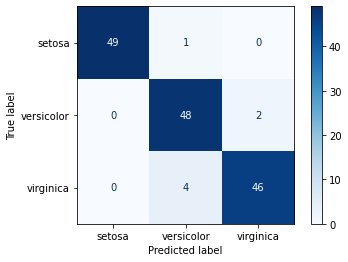

In [387]:
def main():  
  score_dict ={'acc':[], 'f1':[], 'class_f1':[], 'class_precision':[]}
  y_dict = {'y_true':[], 'y_pred':[]}
  X, y, label = load_data()
  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
  for train_index, test_index in kf.split(X,y): 
    X_tr, X_val, y_tr, y_val, X_test, y_test =get_data(X, y, train_index, test_index)
    model = train_model(label, X_tr, y_tr, X_val, y_val)
    y_dict, score_dict=predict(X_test, y_test, score_dict, y_dict, model)
  result(score_dict ,y_dict, label)

if __name__ == "__main__":
    main()